<a href="https://colab.research.google.com/github/Lutris98/21_1Q/blob/master/1.Titanic/Titanic_Prototype.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1.EDA

In [ ]:
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV #model_selection doesn't need mentioning, only the method does
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score #given metric was accuracy

In [ ]:
from google.colab import drive #Korean Army banned me from using os resources so I learned new ways
drive.mount('/content/gdrive')
titanic_df=pd.read_csv('/content/gdrive/MyDrive/Dataset/titanic_train.csv')
test_df=pd.read_csv('/content/gdrive/MyDrive/Dataset/titanic_test.csv') 

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
test_df['Survived']=2
df=pd.concat([titanic_df,test_df],axis=0) #concatenating method in Pandas #Preprocessing needs test data(Never modeling) #Null values are okay until padding

##1)Basic Statistics

In [ ]:
df.head(3) 

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S


In [ ]:
df.info() #objects are strings

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1309 entries, 0 to 417
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  1309 non-null   int64  
 1   Survived     1309 non-null   int64  
 2   Pclass       1309 non-null   int64  
 3   Name         1309 non-null   object 
 4   Sex          1309 non-null   object 
 5   Age          1046 non-null   float64
 6   SibSp        1309 non-null   int64  
 7   Parch        1309 non-null   int64  
 8   Ticket       1309 non-null   object 
 9   Fare         1308 non-null   float64
 10  Cabin        295 non-null    object 
 11  Embarked     1307 non-null   object 
dtypes: float64(2), int64(5), object(5)
memory usage: 132.9+ KB


In [ ]:
df.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,1309.000000,1309.000000,1309.000000,1046.000000,1309.000000,1309.000000,1308.000000
mean,655.000000,0.899924,2.294882,29.881138,0.498854,0.385027,33.295479
std,378.020061,0.853975,0.837836,14.413493,1.041658,0.865560,51.758668
min,1.000000,0.000000,1.000000,0.170000,0.000000,0.000000,0.000000
25%,328.000000,0.000000,2.000000,21.000000,0.000000,0.000000,7.895800
50%,655.000000,1.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,982.000000,2.000000,3.000000,39.000000,1.000000,0.000000,31.275000
max,1309.000000,2.000000,3.000000,80.000000,8.000000,9.000000,512.329200


In [ ]:
df['Fare'].fillna(df['Fare'].mean(), inplace=True)

##2)Basic feature selection 

In [ ]:
df['Family']=df['SibSp']+df['Parch'] #Each feature doesn't mean much on its own
df['Name']=df['Name'].str.extract('([A-Za-z]+)\.') #easiest Regex([] contains letters, +groups the previous part, ()contains part to be remembered, \ignores that . mean any letters)
df=df.drop(['SibSp','Parch','Ticket'], axis=1) #drop method doesn't allow inplacing(Should check results along the way)
df['Name'].value_counts(sort=True) #Even the most worthless data needs a peak

Mr          757
Miss        260
Mrs         197
Master       61
Dr            8
Rev           8
Col           4
Ms            2
Mlle          2
Major         2
Dona          1
Don           1
Capt          1
Lady          1
Sir           1
Jonkheer      1
Mme           1
Countess      1
Name: Name, dtype: int64

In [ ]:
df['Name'].replace(['Rev','Dr','Col','Major','Sir','Don','Mlle','Jonkheer','Mme','Ms','Countess','Capt','Lady','Dona'],['Mr','Mr','Mr','Mr','Mr','Mr','Mr','Mr','Mr','Miss','Miss','Miss','Miss','Miss',],inplace=True) #last3 of Mr is just guessing
df['Name'].value_counts(sort=True)

Mr        785
Miss      266
Mrs       197
Master     61
Name: Name, dtype: int64

##3)Encoding

In [ ]:
for feature in ['Sex', 'Cabin', 'Embarked']:
  print(df[feature].value_counts(sort=True)) #focusing on columns

male      843
female    466
Name: Sex, dtype: int64
C23 C25 C27        6
B57 B59 B63 B66    5
G6                 5
C22 C26            4
F33                4
                  ..
B37                1
D9                 1
D56                1
E58                1
D6                 1
Name: Cabin, Length: 186, dtype: int64
S    914
C    270
Q    123
Name: Embarked, dtype: int64


In [ ]:
df['Cabin']=df['Cabin'].str[:1] #Cabin needs insight that only the first character contains information #pd.str is applicable to series
features=['Cabin','Sex','Embarked']
for feature in features:
  df[feature]=LabelEncoder().fit_transform(df[feature].astype(str)) #changing dtype of series

In [ ]:
df.head(3)

,PassengerId,Survived,Pclass,Name,Sex,Age,Fare,Cabin,Embarked,Family
0,1,0,3,Mr,1,22.0,7.2500,8,2,1
1,2,1,1,Mrs,0,38.0,71.2833,2,0,1
2,3,1,3,Miss,0,26.0,7.9250,8,2,0


#2.Preprocessing(with Visualization)

##1)Imputation

In [ ]:
def count_plot(dataframe, feature, hue=None): #distribution of feature itself #Non-necessary values need initialization to none
  f,ax=plt.subplots(figsize=(10,5))
  sns.countplot(data=dataframe, x=feature, hue=hue) #continuous features need displot
  plt.show()
def bar_plot(dataframe, feature1, feature2, hue=None): #distribution of feature with another
  f,ax=plt.subplots(figsize=(10,5))
  sns.barplot(data=dataframe, x=feature1, y=feature2, hue=hue)
  plt.show()

In [ ]:
df.loc[(df.Age.isnull())&(df.Name=='Mr'),'Age']=40 #Another way to load series object #inside []are all true
df.loc[(df.Age.isnull())&(df.Name=='Mrs'),'Age']=40
df.loc[(df.Age.isnull())&(df.Name=='Miss'),'Age']=20
df.loc[(df.Age.isnull())&(df.Name=='Master'),'Age']=5
df.isna().sum()

PassengerId    0
Survived       0
Pclass         0
Name           0
Sex            0
Age            0
Fare           0
Cabin          0
Embarked       0
Family         0
dtype: int64

In [ ]:
df['Age_band']=0 #for float data in classification
df.loc[df.Age<=15, 'Age_band']=1
df.loc[(df.Age>15)&(df.Age<=30), 'Age_band']=2
df.loc[(df.Age>30)&(df.Age<=45), 'Age_band']=3
df.loc[(df.Age>45)&(df.Age<=60), 'Age_band']=4
df.loc[(df.Age>60)&(df.Age<=75), 'Age_band']=5
df.loc[(df.Age>75)&(df.Age<=90), 'Age_band']=6

In [ ]:
df['Fare_band']=0 #by describe method
df.loc[df.Fare<=7, 'Fare_band']=1
df.loc[(df.Fare>14)&(df.Fare<=28), 'Fare_band']=2
df.loc[(df.Fare>28)&(df.Fare<=35), 'Fare_band']=3
df.loc[(df.Fare>35), 'Fare_band']=4

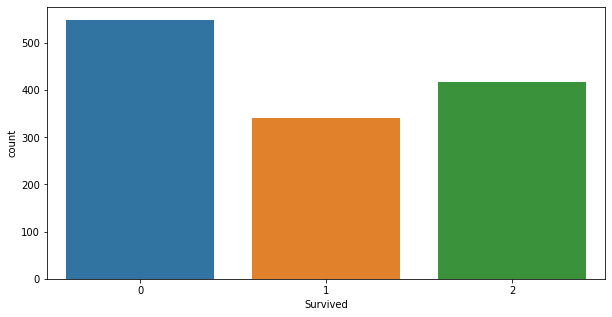

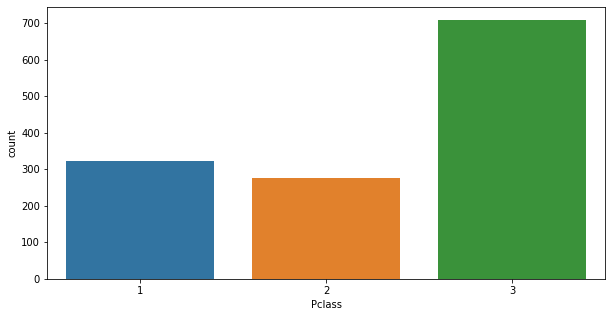

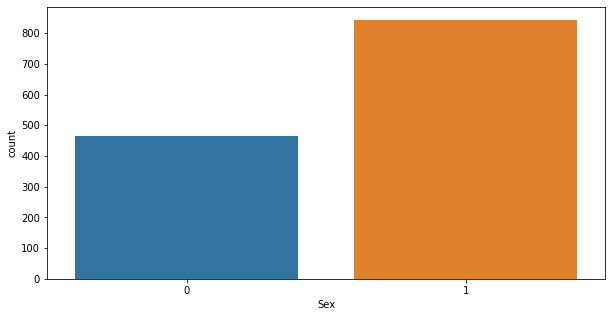

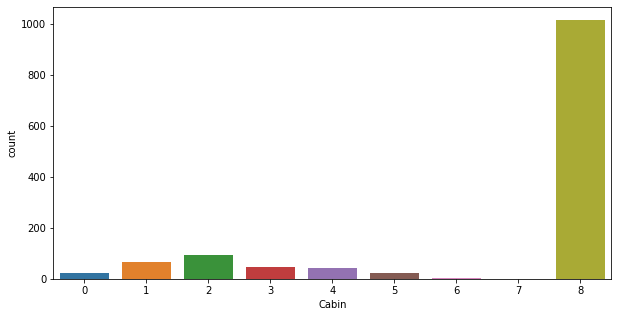

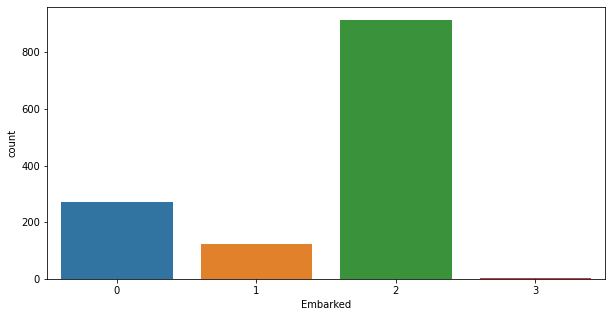

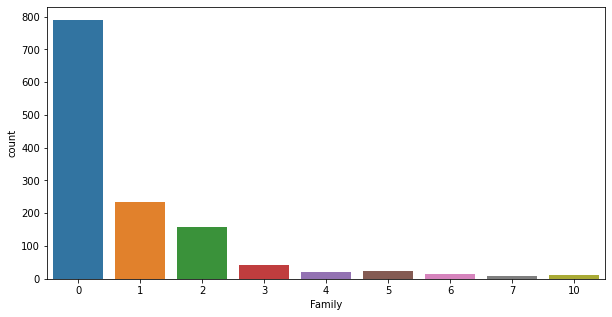

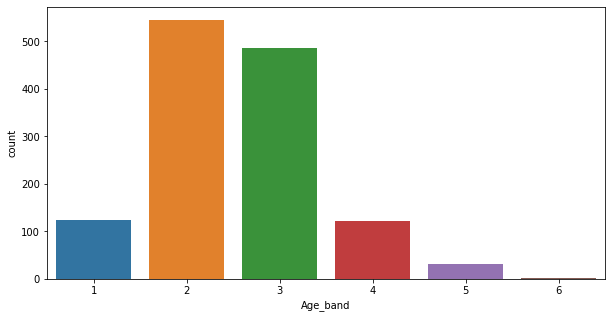

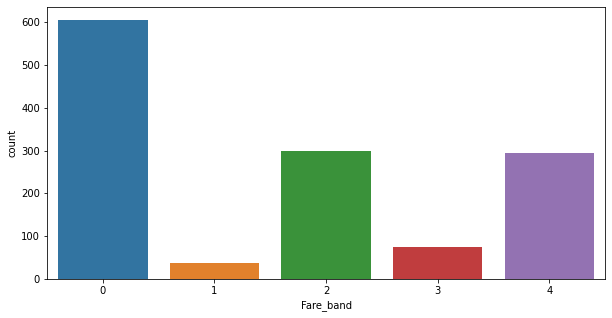

In [ ]:
df_pre=df.drop(['Name','Age','Fare','PassengerId'], axis=1, inplace=False)
features=df_pre.columns.values #columns is dataframe, so make it into ndarray #1.Feature distribution/train&test similarity
df_pre['Test']=0
df_pre.loc[(df_pre.Survived==2),'Test']=1
for feature in features:
    count_plot(df_pre, feature) #hue='Test' for train&test similarity
df_pre.drop('Test',axis=1,inplace=True)

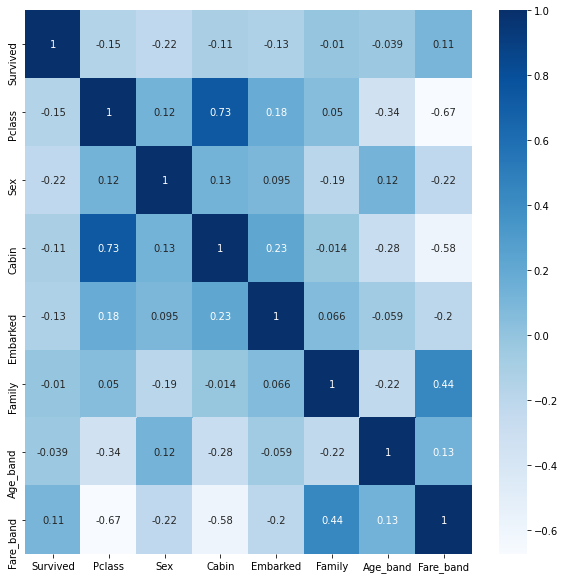

In [ ]:
f=plt.figure(figsize=(10,10))
sns.heatmap(df_pre.corr(), annot=True, cmap='Blues') #annotation is a must #2.Correlation

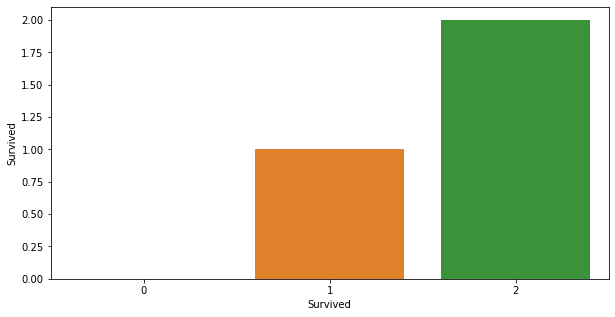

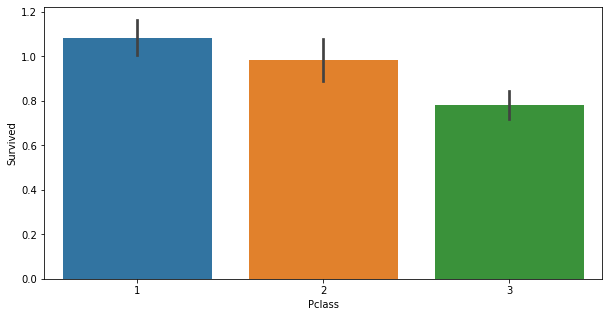

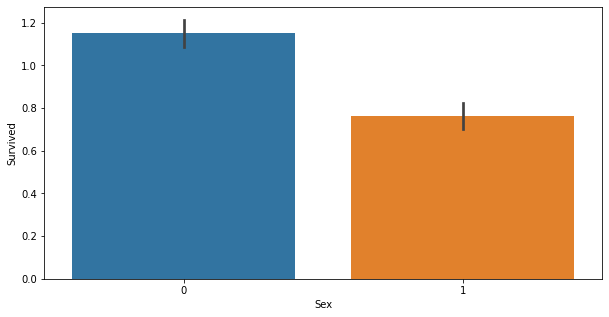

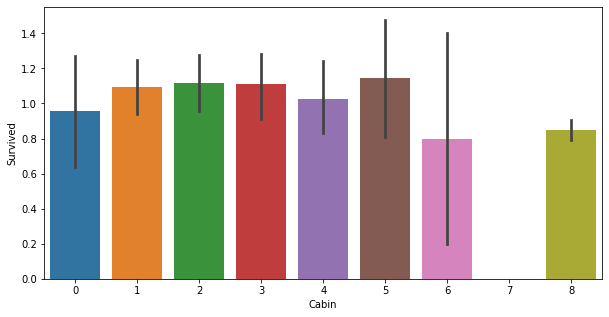

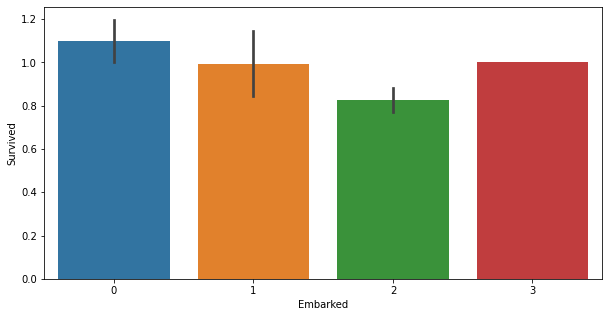

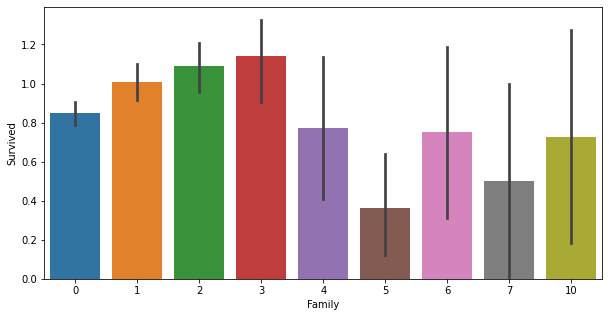

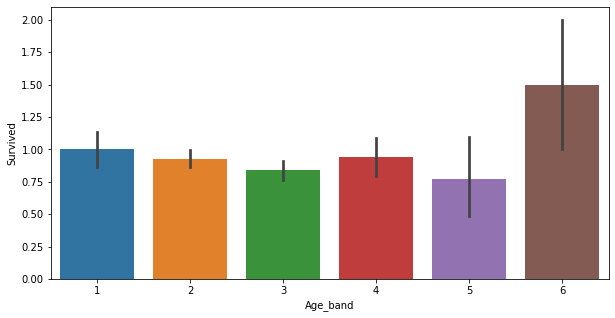

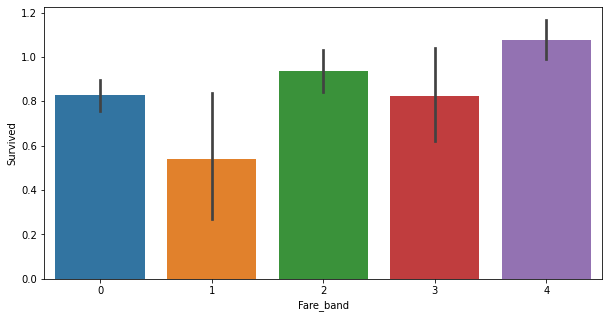

In [ ]:
for feature in features: #3.Impact on target
  bar_plot(df_pre,feature1=feature, feature2='Survived') 

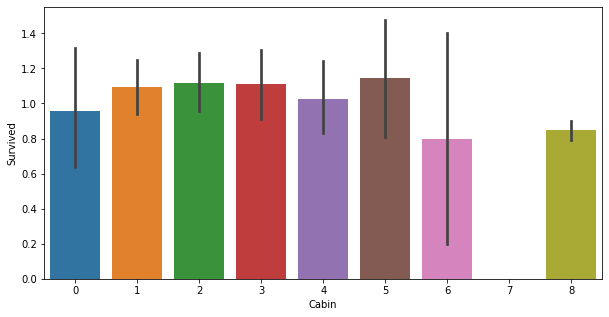

In [ ]:
bar_plot(df,feature1='Cabin', feature2='Survived') 

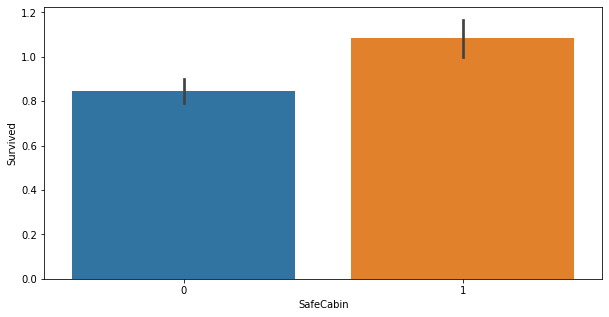

In [ ]:
df['SafeCabin']=0
df.loc[(df.Cabin<=5),'SafeCabin']=1
bar_plot(df,feature1='SafeCabin', feature2='Survived') 

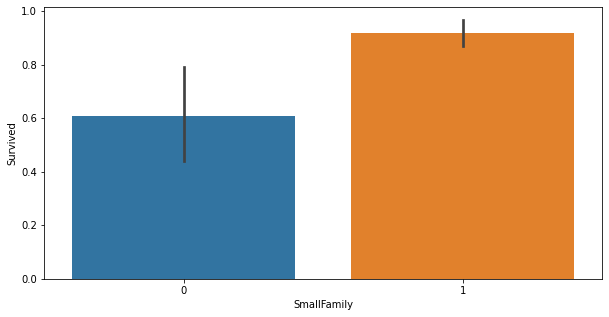

In [ ]:
df['SmallFamily']=0
df.loc[(df.Family<=3),'SmallFamily']=1
bar_plot(df,feature1='SmallFamily', feature2='Survived') 

##2)Scaling&Outliers

#3.CV&Tuning

In [ ]:
df.drop(['Name','Age','Fare','Family','Cabin'],axis=1,inplace=True)

In [ ]:
test_df=df.loc[df['Survived']==2].drop('Survived',axis=1) #Needs division again
titanic_df=df.loc[df['Survived']!=2]
titanic_feature=titanic_df.drop(['Survived','PassengerId'], axis=1) #parameter axis is mandatory
titanic_label=titanic_df['Survived']
titanic_feature.head(3)

,Pclass,Sex,Embarked,Age_band,Fare_band,SafeCabin,SmallFamily
0,3,1,2,2,0,0,1
1,1,0,0,3,4,1,1
2,3,0,2,2,0,0,1


In [ ]:
rf_clf=RandomForestClassifier(random_state=0) #Cross validation need models 
xgb_clf=XGBClassifier(random_state=0)
lgbm_clf=LGBMClassifier(random_state=0)
X_train, X_test, y_train, y_test=train_test_split(titanic_feature, titanic_label, test_size=0.2,random_state=0)

In [ ]:
rf_params={'n_estimators':[50,100,150],
           'max_depth':[3,5,7], #similar to decisiontree
           'min_samples_leaf':[3,5,7],
           'min_samples_split':[5,7,9]}
rf_gridcv=GridSearchCV(rf_clf, param_grid=rf_params, cv=5, n_jobs=-1) #using all CPU cores
rf_gridcv.fit(X_train, y_train)
print('best parameters:\n',rf_gridcv.best_params_)

best parameters:
 {'max_depth': 5, 'min_samples_leaf': 3, 'min_samples_split': 9, 'n_estimators': 50}


In [ ]:
xgb_params={'learning_rate' : [0.02], 
            'n_estimators':[200,300,400],
            'max_depth':[3,5,7],
            'colsample_bytree':[0.7,0.8],
            'subsample':[0.9]}
xgb_gridcv=GridSearchCV(xgb_clf, param_grid=xgb_params, cv=5, n_jobs=-1) 
xgb_gridcv.fit(X_train, y_train)
print('best parameters:\n',xgb_gridcv.best_params_)

best parameters:
 {'colsample_bytree': 0.7, 'learning_rate': 0.02, 'max_depth': 3, 'n_estimators': 200, 'subsample': 0.9}


In [ ]:
lgbm_params={'learning_rate' : [0.02], 
            'n_estimators':[200,300,400],
            'max_depth':[8,10,12],
            'num_leaves':[50],
            'colsample_bytree':[0.7,0.8],
            'subsample':[0.9]}
lgbm_gridcv=GridSearchCV(lgbm_clf, param_grid=lgbm_params, cv=5, n_jobs=-1) 
lgbm_gridcv.fit(X_train, y_train)
print('best parameters:\n',lgbm_gridcv.best_params_)

best parameters:
 {'colsample_bytree': 0.7, 'learning_rate': 0.02, 'max_depth': 8, 'n_estimators': 400, 'num_leaves': 50, 'subsample': 0.9}


#4.Modeling

In [ ]:
rf_clf=rf_gridcv.best_estimator_
xgb_clf=xgb_gridcv.best_estimator_
lgbm_clf=lgbm_gridcv.best_estimator_
vo_clf=VotingClassifier(estimators=[('RandomForest',rf_clf),('XGBoost',xgb_clf),('LightGBM',lgbm_clf)], voting='soft')
pred1=rf_clf.fit(X_train, y_train).predict(X_test)
pred2=xgb_clf.fit(X_train, y_train).predict(X_test)
pred3=lgbm_clf.fit(X_train, y_train).predict(X_test)
pred4=vo_clf.fit(X_train, y_train).predict(X_test)
print('Accuracy1:{0:.4f} Accuracy2:{1:.4f} Accuracy3:{2:4f}'.format(accuracy_score(y_test,pred1), accuracy_score(y_test,pred2),accuracy_score(y_test,pred3)))
print('Final accuracy:{0:.4f}'.format(accuracy_score(y_test,pred4))) #from python3.6 should use fstring formatting  #:separates index and the number

Accuracy1:0.8101 Accuracy2:0.8101 Accuracy3:0.815642
Final accuracy:0.8101


# 1)Uploading

In [ ]:
Pid=test_df['PassengerId']
test_df.drop('PassengerId',axis=1,inplace=True)
test_df.head(3)

,Pclass,Sex,Embarked,Age_band,Fare_band,SafeCabin,SmallFamily
0,3,1,1,3,0,0,1
1,3,0,2,4,1,0,1
2,2,1,1,5,0,0,1


In [ ]:
realpred=vo_clf.predict(test_df) #output of classifier is ndarray object
realpred=pd.DataFrame(realpred, columns=['Survived']) #never forget[]
submit_df=pd.DataFrame({'PassengerId':Pid,'Survived':realpred['Survived']}) #Data set by giving each column name and data
submit_df.head(3)
submit_df.to_csv('/content/gdrive/MyDrive/Dataset/Lutris_titanic.csv', index = False) #The client doesn't want indice on submission

# 2)Feedback<br>
Do not be satisfied with the comfort higher APIs give. Only the ones that understand the lower ver have the right to enjoy.

#3)Afterwords
I thought about this notebook for a week but made it to top33%.<br>
My first competition left me a bit of a warning that things aren't gonna be as rosy as I might dream.<br>
After pouring much thought into it, i skimmed through famous notebooks, but it brought me more despair as I found out that there much simpler notebooks sometimes get much higher scores(that I can't see why), and some I can't understand at my level.<br>
But again, this is a warning. I'm gonna need all the skills I regarded unnecessary, and gonna need read alot. 
There is a bright side. I did learn a lot from this prediction. How I should concatenate train&test data, how important Visualization and Padding can be and so forth.<br>
